# numpy的高性能同构定长数组

numpy最大的意义在于它构建了这个高性能同构定长多维数组数组类型`numpy.ndarray`它是由C写的数据类型因此具有非常强的性能.同时


ndarray实现了`Collection`,` Container`和`Iterable`协议.因此python的序列操作也都可以使用.


`numpy.ndarray`是几乎所有python科学计算工具的基石,包括pandas也是在其上构建的.

In [1]:
import numpy as np

## ndarray数组的基本操作

[ndarray](https://www.numpy.org.cn/reference/array_objects/index.html)本质上是一段连续内存.它支持基本的构造,切片,访问,和修改操作,并且也支持合并操作.

### 构建ndarray数组

numpy的数组需要由序列构建而来.通常我们使用构造函数`numpy.array(obj:sequence,dtype:str,copy:bool=True,order:str,subok:bool=False,ndmin:int)`

在数学上我们定义一个如下的矩阵:
$$ \left [ \begin{matrix}
 0 & 1 &2\\
 3 & 4 &5
\end{matrix}
\right ]
$$

我们以它为例子介绍数组的构建


+ **`obj`是用于转化的序列对象,要求必须是同一种数据类型**

In [2]:
X = np.array([[0,1,2],[1,0,3]])

In [3]:
print(X)

[[0 1 2]
 [1 0 3]]


+ **`dtype`可以用于指定数据类型**

可用的数据类型下面"元素的数据类型"部分会列出,如果不指定则会自动使用可以存放数据的最小内存的数据类型.

numpy可以特化其中元素的类型来获得更高的效率


类型|类型代码|说明
---|---|---
`int8/uint8`|`i1/u1`|`有符号/无符号8位整型`
`int16/uint16`|`i2/u2`|`有符号/无符号16位整型`
`int32/uint32`|`i4/u4`|`有符号/无符号32位整型`
`int64/uint64`|`i8/u8`|`有符号/无符号64位整型`
`float16`|`f2`|`半精度浮点数`
`float32`|`f4或f`|`标准单精度浮点数`
`float64`|`f8或d`|`标准双精度浮点数`
`float128`|`f16或g`|`扩展精度浮点数`
`complex64`|`c8`|`32为浮点数表示的复数`
`complex128`|`c16`|`64为浮点数表示的复数`
`complex256`|`c32`|`128为浮点数表示的复数`
`bool`|`?`|`布尔值`
`object`|`O`|`python对象类型`
`string_`|`SX`|`固定长度字符串,比如长度为10,则S10`
`unicode_`|`UX`|`固定长度unicode,比如长度为10,则U10`


In [4]:
X = np.array([[0,1,2],[1,0,3]],dtype="f2")

In [5]:
print(X)

[[0. 1. 2.]
 [1. 0. 3.]]


In [6]:
X.dtype

dtype('float16')

> 结构体数组

在numpy中可以定义结构数组来表现结构化数据,虽然这个功能现在有pandas这个更好的实现,但如果只是轻量级的使用,numpy的结构数组或许更有效率

构造结构体使用`np.dtype(obj,align:bool=False,copy:bool=True)`类.

要自己构建结构体,其中`obj`需为一个字典,包含两个字段:
+ names 用于指明字段名
+ formats 用于指明字段的类型

同时指明`align=True`用于指明数据要对齐(通过补齐让每个字段自动与最长的字段长度一致).
`copy`则意味着类型是新对象还是只是原来标准类型的映射.

In [7]:
persontype=np.dtype({'names':['name','age','weight'],'formats':['S32','i','f']},align=True)#先创建一个人物类型

In [8]:
People = np.array([
    [("Huang",27,75),("Hao",25,55),("Li",26,80)],
    [("Hu",28,65),("Hua",23,75),("Liu",26,85)]
],dtype=persontype)
print(People)

[[(b'Huang', 27, 75.) (b'Hao', 25, 55.) (b'Li', 26, 80.)]
 [(b'Hu', 28, 65.) (b'Hua', 23, 75.) (b'Liu', 26, 85.)]]


访问某个数据的字段可以使用`[]`运算符

In [9]:
People[0,0]['name']

b'Huang'

也可以直接以字段为索引直接获取切片或全局的字段数组

In [10]:
People[0,:]['name']# 取行

array([b'Huang', b'Hao', b'Li'], dtype='|S32')

In [11]:
People[:,0]['name']# 取列

array([b'Huang', b'Hu'], dtype='|S32')

In [12]:
People['name'] # 全局

array([[b'Huang', b'Hao', b'Li'],
       [b'Hu', b'Hua', b'Liu']], dtype='|S32')

+ `copy`,默认值为True,如果为True,构造出的数组为新建的,否则如果参数`obj`也是ndarray数组,则只是修改这个数组.

In [13]:
X = np.array([[0,1,2],[1,0,3]],dtype="f2")
X_copy = np.array(X,copy=True)
X is X_copy

False

In [14]:
X_self = np.array(X,copy=False)
X is X_self

True

+ **`order`用于标明下标的表现方式,可选的参数有'K', 'A', 'C', 'F',默认为"K"**
    
    在数学上我们定义一个如下的矩阵:
$$ \left [ \begin{matrix}
 0 & 1 &2\\
 3 & 4 &5
\end{matrix}
\right ] 
$$

    在C语言中,中其存储方式是以行为主轴的,也就是会这么存.
    ```shell
    0,1,2,3,4,5
    ```
    而在Fortran中会以列为主轴存储,也就是这样
    ```shell
    0,3,1,4,2,5
    ```
    内部存储的样子比较难以观察,我们可以通过`reshape`来查看
    
    

In [15]:
X = np.array([[0,1,2],[3,4,5]],order="C")
print(X)
X.reshape(1,6,order="C")

[[0 1 2]
 [3 4 5]]


array([[0, 1, 2, 3, 4, 5]])

In [16]:
Y = np.array([[0,1,2],[3,4,5]],order="F")
print(Y)
Y.reshape(1,6,order='F')

[[0 1 2]
 [3 4 5]]


array([[0, 3, 1, 4, 2, 5]])

如果参数指明为"C",则表示使用C语言的规范存储,如果使用参数"F"则表示使用Fortran的规范存储.

"K"和"A"在参数`copy`为False时表示继承`obj`数组的存储顺序,但`copy`为True时则表现不同,"K"在`obj`为数组时继承其顺序,非数组则会按C的格式存储.而"A"会在`obj`为数组时如果它的`order`为"F","A","K"时都是Fortran的存储顺序,否则为C的存储方式.

+ **`subok`如果为True,则子类将被传递;否则返回的数组将被强制为基类数组,False为默认.**

+ `ndmin`指定维度

这个参数更多的是用于将向量,矩阵等转化为更高维的张量,同样的功能也可以用`reshape`实现

In [17]:
X = np.array([[0,1,2],[3,4,5]],ndmin=2)
print(X)

[[0 1 2]
 [3 4 5]]


In [18]:
Y = np.array([[0,1,2],[3,4,5]],ndmin=3)
print(Y)

[[[0 1 2]
  [3 4 5]]]


In [19]:
Z = np.array([[0,1,2],[3,4,5]],ndmin=3)
print(Z)

[[[0 1 2]
  [3 4 5]]]


### 快速构建数组

numpy提供了很多方法快速构建一些特殊形式的数组

> 固定形状固定值的数组

+ 全0数组`np.zeros(shape)`

In [20]:
np.zeros((2,2))

array([[0., 0.],
       [0., 0.]])

+ 全1数组`np.ones(shape)`

In [21]:
np.ones((2,2))

array([[1., 1.],
       [1., 1.]])

+ 空数组(只分配内存空间不赋值,也就是说里面可能是无意义数据)`np.empty(shape)`

In [22]:
np.empty((2,2))

array([[1., 1.],
       [1., 1.]])

> 特殊一维数组

+ 一维等差数列数组`np.arange(dow,up,step)`

In [23]:
np.arange(1,11,2)

array([1, 3, 5, 7, 9])

+ 一维均分数组(可以看做等差数列的一种)`np.linspace(start, stop, num=50, endpoint=True, retstep=False)->sample`

其中`endpoint`如果为True表示`stop`为最后一个数.

如果`retstep`为True,则返回值为(sample,step),其中step就是均分的间隔

In [24]:
np.linspace(-np.pi, np.pi, 6,endpoint=True)

array([-3.14159265, -1.88495559, -0.62831853,  0.62831853,  1.88495559,
        3.14159265])

In [25]:
np.linspace(-np.pi, np.pi, 6,endpoint=True,retstep=True)

(array([-3.14159265, -1.88495559, -0.62831853,  0.62831853,  1.88495559,
         3.14159265]), 1.2566370614359172)

+ 一维等比数列数组`np.logspace(start, stop, num=num, endpoint=endpoint,base = base)`

其中`base参数`可以用来固定底,这样就相当于做乘方了

In [26]:
np.logspace(0.1, 1, 10)

array([ 1.25892541,  1.58489319,  1.99526231,  2.51188643,  3.16227766,
        3.98107171,  5.01187234,  6.30957344,  7.94328235, 10.        ])

In [27]:
np.logspace(0.1, 1, 10,base = 2)

array([1.07177346, 1.14869835, 1.23114441, 1.31950791, 1.41421356,
       1.51571657, 1.62450479, 1.74110113, 1.86606598, 2.        ])

> 特殊二维数组

+ 单位矩阵数组`np.eye(n)`

In [28]:
np.eye(3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

+ 对角矩阵数组`np.diag(obj)`

这个`obj`为一维序列时将会产生一个以其值为对角线其他都是0的对角矩阵;如果如一个方正则会取其对角线组成一个数组

In [29]:
np.diag((1,2,3))

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

In [30]:
np.diag(
    (
        (1,2,3),
        (4,5,6),
        (7,8,9)
    )
)

array([1, 5, 9])

> 构造随机数组


numpy有自己的随机数生成器,它可以作为标准库的补充,其接口基本和标准库的一致,用它可以方便的构造固定shape的随机数组.

像标准库random一样,numpy也可以设置随机种子`np.random.seed(number)`

+ 洗牌

    我们可以以一个一维序列作为输入,生成一个元素随机顺序的数组有两种方式
    + 使用`np.random.permutation`生成一个新的一维序列
    + 就地洗牌使用`np.random.shuffle`,改变原对象的排序

In [31]:
import matplotlib.pyplot as plt

In [32]:
%matplotlib inline

In [33]:
np.random.permutation([1,2,3,4,5,6])

array([1, 6, 5, 4, 2, 3])

In [34]:
a = np.array([1,2,3,4,5,6])
np.random.shuffle(a)
a

array([6, 2, 4, 1, 3, 5])

+ 均匀分布
    
    numpy有3个均匀分布的函数

    + `np.random.rand(d0,d1,...,dn)`0~1返回内的均匀分布
    + `np.random.uniform(low=0.0, high=1.0, size=None)`low到high范围内的均匀分布
    + `np.random.randint(low, high=None, size=None, dtype='l')`low到high范围内整数的均匀分布

In [35]:
np.random.rand(2,3)

array([[0.69799255, 0.7888051 , 0.66893797],
       [0.01018505, 0.93295118, 0.57403557]])

In [36]:
np.random.uniform(2,3,size=(3,4))

array([[2.27883779, 2.10539064, 2.6946143 , 2.99850912],
       [2.381377  , 2.33687032, 2.31932192, 2.96783378],
       [2.46179302, 2.72258605, 2.4427342 , 2.20615523]])

In [37]:
np.random.randint(1,9,size=(3,3))

array([[6, 7, 4],
       [4, 8, 1],
       [4, 3, 3]])

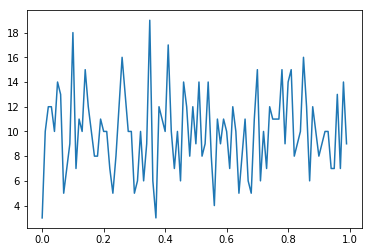

In [38]:
l=np.random.rand(1000)
r1=[len(list(filter(lambda x:i+0.005>x>i-0.005,l))) for i in map(lambda x:round(x*0.01,3),range(0,100,1))]
plt.plot(list(map(lambda x:round(x*0.01,3),range(0,100,1))),r1)
plt.show()

+ 正态分布

   正态分布又叫高斯分布,numpy中有两个方法实现:
   + `np.random.normal(loc=0.0, scale=1.0,size=None)`loc为均值,scale为标准差size则为形状
   + `np.random.randn(d0, d1, ..., dn)`标准正态分布

In [39]:
np.random.normal(1,0.5,size=(3,3))

array([[1.14928514, 0.98874561, 1.08238708],
       [1.16838246, 1.08098035, 0.83320946],
       [2.2213291 , 1.10766759, 0.61062045]])

In [40]:
np.random.randn(3,3)

array([[-0.74651304, -0.52009124,  0.10955316],
       [ 0.32689031, -1.44277601,  0.53329921],
       [ 1.21113617, -0.01221963,  0.88827929]])

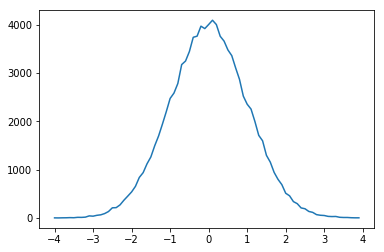

In [41]:
l=np.random.randn(100000)
r1=[len(list(filter(lambda x:i+0.05>x>i-0.05,l))) for i in map(lambda x:round(x*0.1,2),range(-40,40,1))]
plt.plot(list(map(lambda x:round(x*0.1,2),range(-40,40,1))),r1)
plt.show()

+ 二项分布

二项分布是n个独立的是/非试验中成功的次数的离散概率分布,其中每次试验的成功概率为p.这样的单次成功/失败试验又称为伯努利试验.实际上当n = 1时,二项分布就是伯努利分布.二项分布是显著性差异的二项试验的基础.

Poisson分布是二项分布n很大而P很小时的特殊形式,是两分类资料在n次实验中发生x次某种结果的概率分布.其概率密度函数为:
$$ P(x)=e-\mu*\frac {\mu x} {x!} x=0,1,2...n $$

其中e为自然对数的底,$\mu$为总体均数,x为事件发生的阳性数.

二项分布在numpy中使用`np.random.binomial(n, p, size=None)`,n为重复次数,p为True的概率,size为形状

In [42]:
sum(np.random.binomial(10,0.1,1000)==0)/1000.0# 10个样本成功率为0.1,验证1000次全部都失败的概率

0.363

+ Beta分布

使用函数`np.random.beta(a, b, size=None)`a为分布的参数$\alpha$,b为参数$\beta$

In [43]:
np.random.beta(0.5,0.3,[2,3])

array([[0.96751372, 0.89294397, 0.01424346],
       [0.32563002, 0.99996309, 0.69713176]])

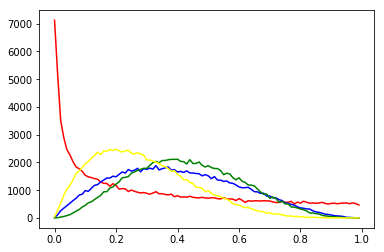

In [44]:
l0=np.random.beta(0.5,1,100000)
l1=np.random.beta(2,3,100000)
l2=np.random.beta(3,4,100000)
l3=np.random.beta(2,5,100000)
r0=[len(list(filter(lambda x:i+0.005>x>i-0.005,l0))) for i in map(lambda x:round(x*0.01,3),range(0,100,1))]
r1=[len(list(filter(lambda x:i+0.005>x>i-0.005,l1))) for i in map(lambda x:round(x*0.01,3),range(0,100,1))]
r2=[len(list(filter(lambda x:i+0.005>x>i-0.005,l2))) for i in map(lambda x:round(x*0.01,3),range(0,100,1))]
r3=[len(list(filter(lambda x:i+0.005>x>i-0.005,l3))) for i in map(lambda x:round(x*0.01,3),range(0,100,1))]
plt.plot(list(map(lambda x:round(x*0.01,3),range(0,100,1))),r0,color="red")
plt.plot(list(map(lambda x:round(x*0.01,3),range(0,100,1))),r1,color="blue")
plt.plot(list(map(lambda x:round(x*0.01,3),range(0,100,1))),r2,color="green")
plt.plot(list(map(lambda x:round(x*0.01,3),range(0,100,1))),r3,color="yellow")
plt.show()

+ 卡方分布

若k个随机变量$ Z_1、……、Z_k $是相互独立,符合标准正态分布的随机变量(数学期望为0,方差为1),则随机变量Z的平方和

$$ X=\sum_{i=1}^k Z_i^2 $$

被称为服从自由度为k的卡方分布,记作

$$ X\sim\chi^2(k) $$
    
$$ X\sim\chi^2_k $$

numpy中使用接口`np.random.chisquare(df, size=None)`其中df为分布的参数,自由度$df$

In [45]:
np.random.chisquare(2,(2,3))

array([[1.2339406 , 2.84964228, 3.60035737],
       [0.33187465, 3.02932834, 4.39024623]])

+ 伽马分布

伽马分布使用接口`np.random.gamma(shape, scale=1.0, size=None)`shape表示形状参数$\alpha$;scale为尺度参数$\beta$

In [46]:
np.random.gamma(1,2,(2,3))

array([[3.17820824, 2.53817032, 1.49755265],
       [0.24098586, 1.61370319, 0.48898025]])

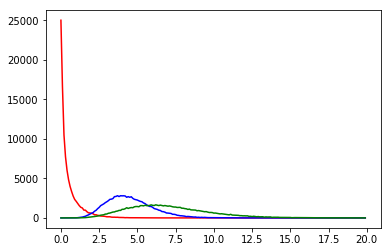

In [47]:
l0=np.random.gamma(0.5,1,100000)
l1=np.random.gamma(9,0.5,100000)
l2=np.random.gamma(7,1,100000)
r0=[len(list(filter(lambda x:i+0.05>x>i-0.05,l0))) for i in map(lambda x:round(x*0.1,3),range(0,200,1))]
r1=[len(list(filter(lambda x:i+0.05>x>i-0.05,l1))) for i in map(lambda x:round(x*0.1,3),range(0,200,1))]
r2=[len(list(filter(lambda x:i+0.05>x>i-0.05,l2))) for i in map(lambda x:round(x*0.1,3),range(0,200,1))]
plt.plot(list(map(lambda x:round(x*0.1,3),range(0,200,1))),r0,color="red")
plt.plot(list(map(lambda x:round(x*0.1,3),range(0,200,1))),r1,color="blue")
plt.plot(list(map(lambda x:round(x*0.1,3),range(0,200,1))),r2,color="green")
plt.show()

> 根据下标自定义数组构造过程

有的时候我们希望可以自定义的生成一个矩阵,比如我们希望生成一个各项值等于i+10j的矩阵(i为行号,j为列号)这时候可以使用`np.fromfunction(func,shape,dtype)`

其中的参数`func`的参数个数为`shape`的位数,而参数的值则是下标

In [48]:
np.fromfunction(lambda i,j: i+10*j,(3,4))

array([[ 0., 10., 20., 30.],
       [ 1., 11., 21., 31.],
       [ 2., 12., 22., 32.]])

> 网格数组 

`np.ogrid`可以用于快速构建用于构建网格的数组.他的参数是切片表达式,每有一个切片就会生成一个网格的一根轴,因此他的返回数据个数与参数个数一致.

In [49]:
x,y = np.ogrid[:5,:10:2]
print(x)
print(y)

[[0]
 [1]
 [2]
 [3]
 [4]]
[[0 2 4 6 8]]


可以看到这两个数组一个行一个是列,且每位对称,这样做出来的数组就可以直接进行矩阵乘法了

In [50]:
x@y

array([[ 0,  0,  0,  0,  0],
       [ 0,  2,  4,  6,  8],
       [ 0,  4,  8, 12, 16],
       [ 0,  6, 12, 18, 24],
       [ 0,  8, 16, 24, 32]])

利用ogrid的返回值可以很容易的计算出二元函数在等间距网格上的值

例:画出
$$f(x,y)=xe^{x^2-y^2}$$

In [51]:
x,y = np.ogrid[-2:2:20j,-2:2:20j]
z = x*np.exp(-x**2-y**2)

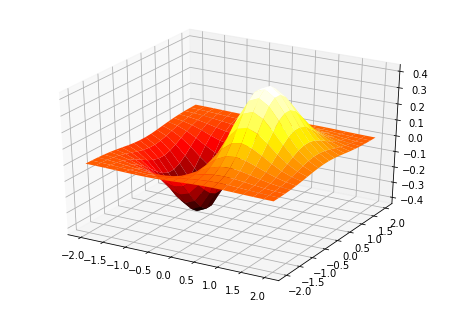

In [52]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(x, y, z, rstride=1, cstride=1, cmap='hot')

plt.show()


### ndarray对象的常用属性

属性|含义
---|---
`T`|转置,与`self.transpose()`相同,如果维度小于2返回self
`size`|数组中元素个数
`itemsize`|数组中单个元素的字节长度
`dtype`|数组元素的数据类型对象
`ndim`|数组的维度
`shape`|数组的形状
`data`|指向存放数组数据的[`memoryview`对象](http://blog.hszofficial.site/TutorialForPython/%E8%AF%AD%E6%B3%95%E7%AF%87/%E6%96%87%E6%9C%AC%E4%B8%8E%E5%AD%97%E8%8A%82%E5%BA%8F/%E5%AD%97%E8%8A%82%E5%BA%8F%E5%88%97%E4%B8%8E%E5%86%85%E5%AD%98%E8%A7%86%E5%9B%BE.html#memoryview)
`flat`|返回数组的一维迭代器
`imag`|返回数组的虚部
`real`|返回数组的实部
`nbytes`|数组中所有元素的字节长度


ndarray也支持一些方法,这些方法与numpy对应函数重名.这边就不做详细介绍了

### 访问ndarray中的元素

访问某个元素可以像访问多维list对象中元素一样操作

In [53]:
X

array([[0, 1, 2],
       [3, 4, 5]])

In [54]:
X[0][1]

1

也可以使用切片的方式,以`,`分隔每维来指定位置

In [55]:
X[0,1]

1

### ndarray数组的切片

数字切片的规则和python中list一致,

+ 以`,`分隔每维来指定位置.
+ 以`:`代表范围,如果`:`之前或者之后缺省,则分别代表最初一位和最后一位.正整数数代表从头数到这位,复数代表从末位倒着数到这位
+ `,`分隔的每一位都可以以一个list指定取某几位

In [56]:
X[:,1]

array([1, 4])

In [57]:
X[:,:-1]

array([[0, 1],
       [3, 4]])

In [58]:
X[:,[0,-1]]

array([[0, 2],
       [3, 5]])

### 按下表提取元素


numpy中是用`np.take(a, indices, axis=None, out=None, mode='raise')`从数组总提取对应的下标指示的元素构建一个新数组

In [59]:
x = np.arange(10)
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [60]:
np.take(x,[1,2,3])

array([1, 2, 3])

### 按条件查找下标对应的元素

numpy支持按条件查找下标对应的元素,使用的接口是`np.choose(a, choices, out=None, mode='raise')`

其中a为指定的下标组成的序列,choices为可被选择的内容,

In [61]:
choices = [
    [0, 1, 2, 3], 
    [10, 11, 12, 13], 
    [20, 21, 22, 23], 
    [30, 31, 32, 33]
]

In [62]:
np.choose([2, 3, 1, 0], choices)

array([20, 31, 12,  3])

可以看到最后的结果是每列选择对应下标的值

### 按条件查找元素下标

numpy支持按条件查找元素所在下标,使用的接口是`np.where`,它有两种用法:

+ `np.where(condition, [x, y])`来按条件查找元素并执行赋值.

    其逻辑是:满足条件(condition),输出x,不满足输出y.condition是判断条件.

In [63]:
aa = np.arange(10)
np.where(aa,1,-1)
# 0值也是False

array([-1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [64]:
np.where(aa > 5,1,-1)
# condition为一个bool值序列

array([-1, -1, -1, -1, -1, -1,  1,  1,  1,  1])

In [65]:
np.where(
    [
        [True,False], 
        [True,True]
    ],    # 官网上的例子
     [
         [1,2], 
         [3,4]
     ],
     [
         [9,8], 
         [7,6]
     ]
)
## 多维数组则是看对应下标位置判断取值

array([[1, 8],
       [3, 4]])

+ `np.where(condition)`返回满足条件的下标,即等价于`condition.nonzero()`

In [66]:
np.where(aa>5)

(array([6, 7, 8, 9]),)

In [67]:
np.where(np.array([[0,1],
                   [1,0]]) > 0)

(array([0, 1]), array([1, 0]))

**使用where实现三角波**

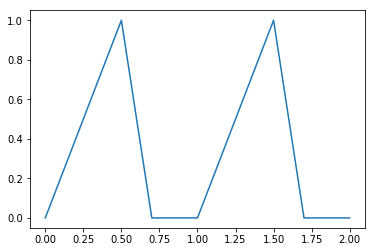

In [68]:
T=1#定义周期T为1
x = np.linspace(0, 2,201,endpoint=True)
C = 0.7#定义为0的部分
up = 0.5#定义上升的持续时间
top = 1.0#定义最大y值
#y=Kx+B
K_up = lambda : top/up
K_down = lambda : top/(up-C)
B_down = top-K_down()*up
y = np.where(np.modf(x)[0] >= C ,0,np.where(np.modf(x)[0]<=up,K_up()*np.modf(x)[0],
                                            K_down()*np.modf(x)[0]+B_down))
plt.plot(x,y)
plt.show()

### 按条件条件查找元素

numpy支持按条件查找元素,使用的是接口`np.select(condlist, choicelist, default=0)`.
当满足多个条件时，将使用condlist中遇到的第一个条件.位置m处的输出是choicelist中数组的第m个元素，其中condlist中相应数组的第m个元素为True。

In [69]:
x = np.arange(10)
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [70]:
condlist = [x<3, x>5]
condlist

[array([ True,  True,  True, False, False, False, False, False, False,
        False]),
 array([False, False, False, False, False, False,  True,  True,  True,
         True])]

In [71]:
choicelist = [x, x**2]
choicelist

[array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 0,  1,  4,  9, 16, 25, 36, 49, 64, 81])]

In [72]:
np.select(condlist, choicelist)

array([ 0,  1,  2,  0,  0,  0, 36, 49, 64, 81])

**使用select实现三角波**

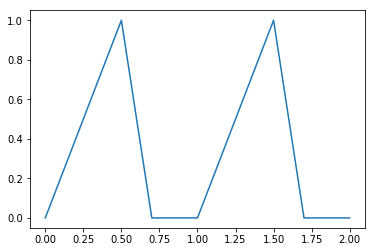

In [74]:
T=1#定义周期T为1
x = np.linspace(0, 2,201,endpoint=True)
C = 0.7#定义为0的部分
up = 0.5#定义上升的持续时间
top = 1.0#定义最大y值
#y=Kx+B
K_up = lambda : top/up
K_down = lambda : top/(up-C)
B_down = top-K_down()*up
y1 = np.select([np.modf(x)[0] >= C,np.modf(x)[0]<=up,True],
               [0,K_up()*np.modf(x)[0],K_down()*np.modf(x)[0]+B_down])
plt.plot(x,y1)
plt.show()

### 数组分段执行函数

`np.piecewise(x, condlist, funclist, *args, **kw)`可以按condlist将x拆成几段,每段分别执行funclist中对应的函数

**使用piecewise实现三角波**

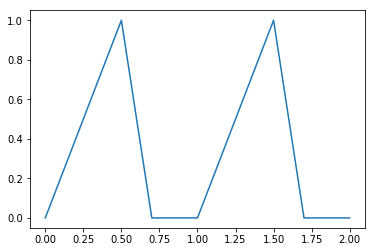

In [75]:
y2 = np.piecewise(
    x,
    [np.modf(x)[0] >= C,np.modf(x)[0]<=up],
    [0,lambda x: K_up()*np.modf(x)[0],lambda x:K_down()*np.modf(x)[0]+B_down]
)
plt.plot(x,y2)
plt.show()

### 数组拼接

二维数组拼接分为横向拼接和纵向拼接

+ `np.hstack(tup)`横向拼接
+ `np.vstack(tup)`纵向拼接

其中tup为要拼接的对象组成的序列

更加通用的则是指定要拼接的轴`np.concatenate(tup,axis=0,out=None)`其中用axis指定以第几维为轴,out如果设置则必须为符合拼接后形状,元素类型的数组对象,这样拼接的结果会放入这个数组.


In [76]:
A=np.arange(1,13).reshape(3,4)
print(A)

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]]


In [77]:
B=np.arange(2,14).reshape(3,4)
print(B)

[[ 2  3  4  5]
 [ 6  7  8  9]
 [10 11 12 13]]


In [78]:
np.hstack((A,B))

array([[ 1,  2,  3,  4,  2,  3,  4,  5],
       [ 5,  6,  7,  8,  6,  7,  8,  9],
       [ 9, 10, 11, 12, 10, 11, 12, 13]])

In [79]:
np.vstack((A,B))

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [ 2,  3,  4,  5],
       [ 6,  7,  8,  9],
       [10, 11, 12, 13]])

In [80]:
np.concatenate((A,B),axis=0)

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [ 2,  3,  4,  5],
       [ 6,  7,  8,  9],
       [10, 11, 12, 13]])

In [81]:
np.concatenate((A,B),axis=1)

array([[ 1,  2,  3,  4,  2,  3,  4,  5],
       [ 5,  6,  7,  8,  6,  7,  8,  9],
       [ 9, 10, 11, 12, 10, 11, 12, 13]])

## 序列操作

作为一个序列,numpy也提供了很多序列专有操作,这些操作看起来有点函数式编程的意思.习惯这种思维的可以很方便的写出简洁的代码



### 真值判断

numpy使用`any(a,axis=None)`和`all(a,axis=None)`进行真值判断.,同时可以指定轴.

In [82]:
x = np.array([0,1,2,3,4,5,6])

In [83]:
np.all(x)

False

In [84]:
np.any(x)

True

### 迭代器

numpy使用`np.nditer`将数组转化为迭代器.它支持python的迭代器协议,可以使用next获取下一个元素.`order`参数可以直接影响它的迭代顺序.

In [85]:
x = np.array([1,2,3,4,5,6]).reshape(2,3)
print(x)
x_i = np.nditer(x,order='C')

[[1 2 3]
 [4 5 6]]


In [86]:
for i in x_i:
    print(i)

1
2
3
4
5
6


In [87]:
x_j =  np.nditer(x,order='F')

In [88]:
for i in x_j:
    print(i)

1
4
2
5
3
6


### 排序

+ `np.lexsort(keys, axis=-1)`

使用一系列键执行间接排序,keys为要排序的复数序列.axis为以谁为轴,返回的是排序后的下标位置

In [89]:
X = np.array([
    [9,4,0,4,0,2,1],# b
    [1,5,1,4,3,4,4] # a
])
# b在前，a在后，即是先按照a的元素进行比较
# 如a中的最小值为两个1，其索引分别为0,2，再计较b中相应索引上的值，即9,0
# 对应的最小应是：1,0，而其对应的索引为2，所以排序后返回的结果第一个值为索引2
# 下一个最小应是：1,9，而其对应的索引为0，所以排序后返回的结果第一个值为索引0
# 以此类推...
ind = np.lexsort(X) # Sort by a, then by b
print(ind)

[2 0 4 6 5 3 1]


+ `np.argsort(a, axis=-1, kind='quicksort', order=None)`
    
    排序并返回下标
    + a ：所需排序的数组 
    + axis：数组排序时的基准，axis=0，按行排列；axis=1，按列排列 
    + kind：数组排序时使用的方法，其中:kind=′quicksort′为快排；kind=′mergesort′为混排；kind=′heapsort′为堆排； 
    + order：一个字符串或列表，可以设置按照某个属性进行排序

In [90]:
a=np.array([4,2,5,7,3])
b=np.argsort(a)
print(b)

# 列表b的元素表示的是原列表a中的元素的索引，5各元素的索引分别为0-4
# 返回的结果可以这样解读：
#   b[0]=1，表示原列表a的最小元素的索引为1，即原列表a中的第2个元素为最小值
#   b[1]=4，表示原列表a的第二小元素的索引为4，即原列表a中的第5个元素为第二小元素
#   ...
#   b[4]=3，表示原列表a中的最大元素的索引为3，即原列表a中的第4个元素为最大值

[1 4 0 2 3]


In [91]:
c=np.array([
    [3, 2],
    [5, 7]
])
d = np.argsort(c, axis=1)
print(d)
# axis=1，表明按照列进行排序，即是对[3, 2]进行排序，所以得到索引为[1, 0],其他同理


[[1 0]
 [0 1]]


In [92]:
e = np.argsort(c, axis=0)
print(e)
# axis=0，表明按照行进行排序，即是对[3, 5]进行排序，所以得到索引为[0, 1],其他同理

[[0 0]
 [1 1]]


+ `np.sort(a, axis=-1, kind='quicksort', order=None)`

    这个接口与标准排序接口`sorted`类似功能
    + a ：所需排序的数组 
    + axis：数组排序时的基准，axis=0，按行排列；axis=1，按列排列 
    + kind：数组排序时使用的方法，其中:kind=′quicksort′为快排；kind=′mergesort′为混排；kind=′heapsort′为堆排； 
    + order：一个字符串或列表，可以设置按照某个属性进行排序,有点类似标准接口的key

In [93]:
dtype = [('name', 'S10'), ('height', float), ('age', int)]
values = [('Arthur', 1.8, 41), ('Lancelot', 1.9, 38),('Galahad', 1.7, 38)]
a = np.array(values, dtype=dtype)
print(a)
np.sort(a, order='height')

[(b'Arthur', 1.8, 41) (b'Lancelot', 1.9, 38) (b'Galahad', 1.7, 38)]


array([(b'Galahad', 1.7, 38), (b'Arthur', 1.8, 41),
       (b'Lancelot', 1.9, 38)],
      dtype=[('name', 'S10'), ('height', '<f8'), ('age', '<i8')])

+ `np.searchsorted(a, v, side='left', sorter=None)`

    排序后插入v时插入的索引位置
    + a：所需排序的数组 
    + v：待查询索引的元素值 
    + side：查询索引时的方向，其中:kind=′left′为从左至右；kind=′right′为从右至左 
    + sorder：一个字符串或列表，可以设置按照某个属性进行排序

In [94]:
list3=[1,2,3,4,5]
np.searchsorted(list3,2)
# 如若要在list3中插入元素2，则应当将其插在原列表索引为1的地方，即是插在元素1的后面

1

In [95]:
np.searchsorted(list3,[-5,7,4,9])
# 如若要在list3中插入元素-5，则应当将其插在原列表索引为0的地方，即是插在元素1的前面
# 其他以此类推...

array([0, 5, 3, 5])

+ `np.partition(a, kth, axis=-1, kind='introselect', order=None)`

    + a:所需排序的数组 
    + kth:以排序后第几个数为分界
    + axis: 以哪一维为轴
    + side:查询索引时的方向，其中:kind=′left′为从左至右；kind=′right′为从右至左 
    + sorder:一个字符串或列表，可以设置按照某个属性进行排序

In [96]:
list4=[3,4,5,2,1]
np.partition(list4,3)
# 以排序后的第3个数，即3进行分区，分区后的结果即是：
# 小于3的元素2,1位于3的前面，大于等于3的元素4,5位于3的后面

array([2, 1, 3, 4, 5])

### 累积

其基本模式是延一条轴用一个函数计算到当前位的累积

+ 求沿给定轴的元素的累积积`np.cumprod(a, axis=None, dtype=None, out=None)`

In [97]:
a = np.array([1,2,3,4])
np.cumprod(a) 
# 结果每位是到这一位前各个的积 1, 1*2, 1*2*3 ,1*2*3*4

array([ 1,  2,  6, 24])

In [98]:
a = np.array([
    [1, 2, 3], 
    [4, 5, 6]
])
np.cumprod(a, axis=0)
# 求各个列的累积积
# [ 1,  2,  3],
# [ 1*4, 2*5, 3*6]]

array([[ 1,  2,  3],
       [ 4, 10, 18]])

In [99]:
np.cumprod(a,axis=1)
# 求各行的累积积
# [ 1,  1*2,  1*2*3],
# [ 4,  4*5,  4*5*6]

array([[  1,   2,   6],
       [  4,  20, 120]])

+ 沿给定轴的元素的累积和`np.cumsum(a, axis=None, dtype=None, out=None)`

In [100]:
a = np.array([
    [1, 2, 3], 
    [4, 5, 6]
])
np.cumsum(a, axis=0)
# 求各个列的累积和
# [ 1,  2,  3],
# [ 1+4, 2+5, 3+6]]

array([[1, 2, 3],
       [5, 7, 9]])

In [101]:
np.cumsum(a,axis=1)
# 求各行的累积积
# [ 1,  1+2,  1+2+3],
# [ 4,  4+5,  4+5+6]

array([[ 1,  3,  6],
       [ 4,  9, 15]])

### 差分diff

求沿给定轴axis的第n个离散差分`diff(a, n=1, axis=-1)`(常用在时间序列)

In [102]:
x = np.array([1, 2, 4, 7, 0])
np.diff(x)
# [2-1,4-2,7-4,0-7]

array([ 1,  2,  3, -7])

In [103]:
x = np.array([[1, 3, 6, 10], [0, 5, 6, 8]])
np.diff(x)
# [[3-1,6-3,10-6],
# [5-0,6-5,8-6]]

array([[2, 3, 4],
       [5, 1, 2]])